In [156]:
# Importo las bibliotecas básicas:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')  # Para evitar los molestos avisos.
%matplotlib inline

In [157]:
# Read data
data = pd.read_csv('datos.csv')

In [158]:
# Clean data

# Problems with errors
zero_time = np.where(data['notape'] <= 1e-17)
print("Datos con errores")
print(zero_time)
data.drop(zero_time[0], inplace = True)

# Fixing columns names
data.rename(columns={
    key: key.strip() for key in data.keys()
    }, inplace = True)

# Fixing string values
for col in data.columns:
    if type(data[col][0]) == str:
        data[col] = [val.strip() for val in data[col]]

Datos con errores
(array([], dtype=int64),)


In [159]:
# Mapear las variables categóricas a números
categoricals_columns= ['problem','criterion']

# fetch all values in problem column
problem_values= list(set(data['problem'].values))
criterion_values= list(set(data['criterion'].values))

# Por cada valor cambiarlo en el dataframe por su indice en la lista
for problem in problem_values:
    data['problem'].replace(problem, problem_values.index(problem), inplace=True)
for criterion in criterion_values:
    data['criterion'].replace(criterion, criterion_values.index(criterion), inplace=True)

# Ordenar las columnas con 'tape' , 'notape' y 'ratio' como primeras
columns = data.columns.values
columns = np.append(['tape','notape','ratio'], columns[~np.in1d(columns, ['tape','notape','ratio'])])
data = data[columns]

# Convertir las variables categóricas en variables ficticias o dummies:

# data = pd.get_dummies(data)


In [160]:
def describe(data):
    print(data.describe())
    print(data.info())
    
    plot_boxplot(data, 'ratio')

def plot_boxplot(data, key:str):
    """
    Plot a boxplot using the dataframe indexing on key
    """
    plt.boxplot(data[key])
    plt.title(f"Box Plot {key}")
    plt.legend([key])
    plt.show()

def iqr(data, key):
    """
    Calculates the IQR from the data associated with key
    """
    Q1 = np.percentile(data[key], 25,
                interpolation = 'midpoint')
  
    Q3 = np.percentile(data[key], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def get_outliers(data, key, upper=True):
    """
    Returns the outliers of data[key]
    """
    Q1, Q3, IQR = iqr(data,key)
    if upper:
        return data[data[key] >= Q3 + IQR*1.5]
    return data[data[key] <= Q1 - IQR*1.5]

def remove_outliers(data, key, remove_upper=True, remove_lower=True):
    """
    Returns the data in key without the outliers 
    """
    base_data = data
    if remove_upper:
        base_data = base_data[~base_data.isin(get_outliers(data, key))]
    if remove_lower:
        base_data = base_data[~base_data.isin(get_outliers(data, key, False))]
    return base_data

def plot_corr(df,size=10):
    """
    Function plots a graphical correlation matrix
    for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """

    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm').set_precision(2)
    fig, ax = plt.subplots(figsize=(size+size/2.0, size))
    # ax.matshow(corr)
    # plt.xticks(range(len(corr.columns)), corr.columns)
    # plt.yticks(range(len(corr.columns)), corr.columns)
    
    sns.heatmap(corr,
            cmap='coolwarm',
            annot=True,
            )

def plot_scatter_matrix(data, keys:tuple):
    pd.plotting.scatter_matrix(data.loc[:,keys])
    
def anova(data, factor, objetive, alpha=0.1):
    # TODO Check for assumptions
    import scipy.stats as stats
    levels = set(data[factor])
    levels = [data[objetive][data[factor] == level] for level in levels]
    result = stats.f_oneway(*levels)
    if result.pvalue < alpha:
        # H0 is rejected
        print(f"ANOVA: {factor} influences {objetive}")
    else:
        print(f"ANOVA: {factor} does not influences {objetive}")
    print(result.pvalue)

              tape       notape        ratio      problem    criterion  \
count  2427.000000  2427.000000  2427.000000  2427.000000  2427.000000   
mean     48.759323    32.707729     2.259434     2.951792     2.529048   
std     216.677229   163.371674     0.718694     1.968775     1.729753   
min       0.001000     0.001000     0.500000     0.000000     0.000000   
25%       0.227500     0.079000     1.730769     1.000000     1.000000   
50%       1.598000     0.625000     2.156309     3.000000     3.000000   
75%       6.734000     3.448000     2.713047     5.000000     4.000000   
max    2764.391000  2507.304000    12.000000     6.000000     5.000000   

            routes   iterations      clients    maxroutes      current   total  
count  2427.000000  2427.000000  2427.000000  2427.000000  2427.000000  2427.0  
mean     17.873094    36.799753    57.189122     0.517923    15.504326    30.0  
std      18.512611    28.247469    34.002341     0.499782     8.657081     0.0  
min      

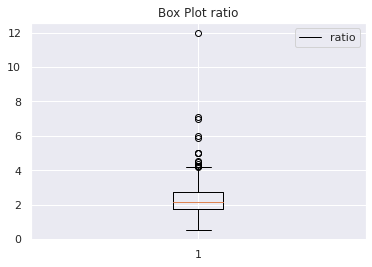

In [161]:
# p1 = data[data['problem'] == "A-N32-K5"]
# p1.head()


# Resumen de estadística descriptiva:
describe(data)

<AxesSubplot:xlabel='ratio', ylabel='Density'>

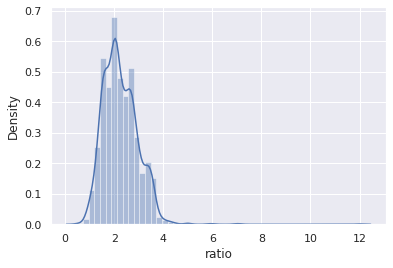

In [162]:
# Histograma:

sns.distplot(data['ratio'])

# plot_corr(data)
# get_outliers(data, 'ratio').describe()
# get_outliers(data, 'ratio', False).describe()

# remove_outliers(data, "ratio").describe()
# data.describe()
# plot_corr(data)
# plot_scatter_matrix(data, ('notape', 'tape'))
# anova(data, "problem", "ratio")



In [163]:
# Asimetría y curtosis:

print("Skewness: %f" % data['ratio'].skew())
print("Kurtosis: %f" % data['ratio'].kurt())

Skewness: 1.710658
Kurtosis: 15.282201


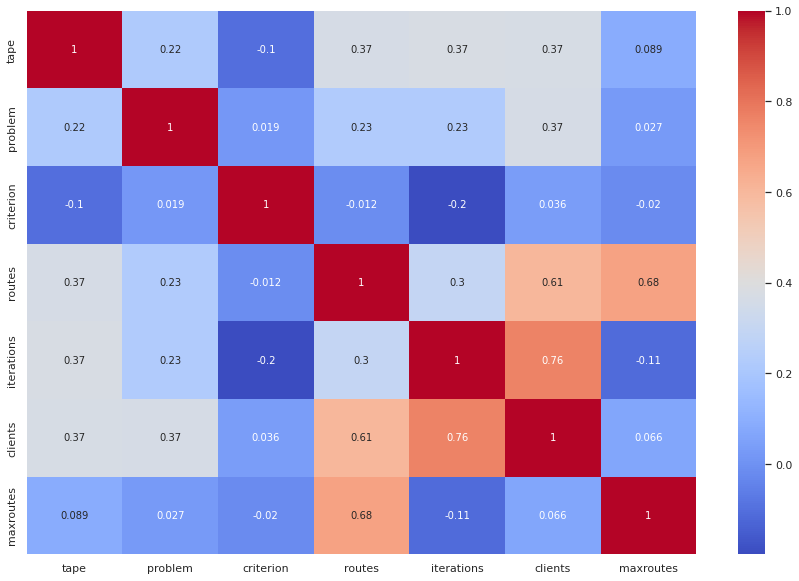

In [164]:
# Matriz de correlación:

#plot_corr(data)
data1= data.drop(['current','total','notape','ratio'], axis=1)

plot_corr(data1)

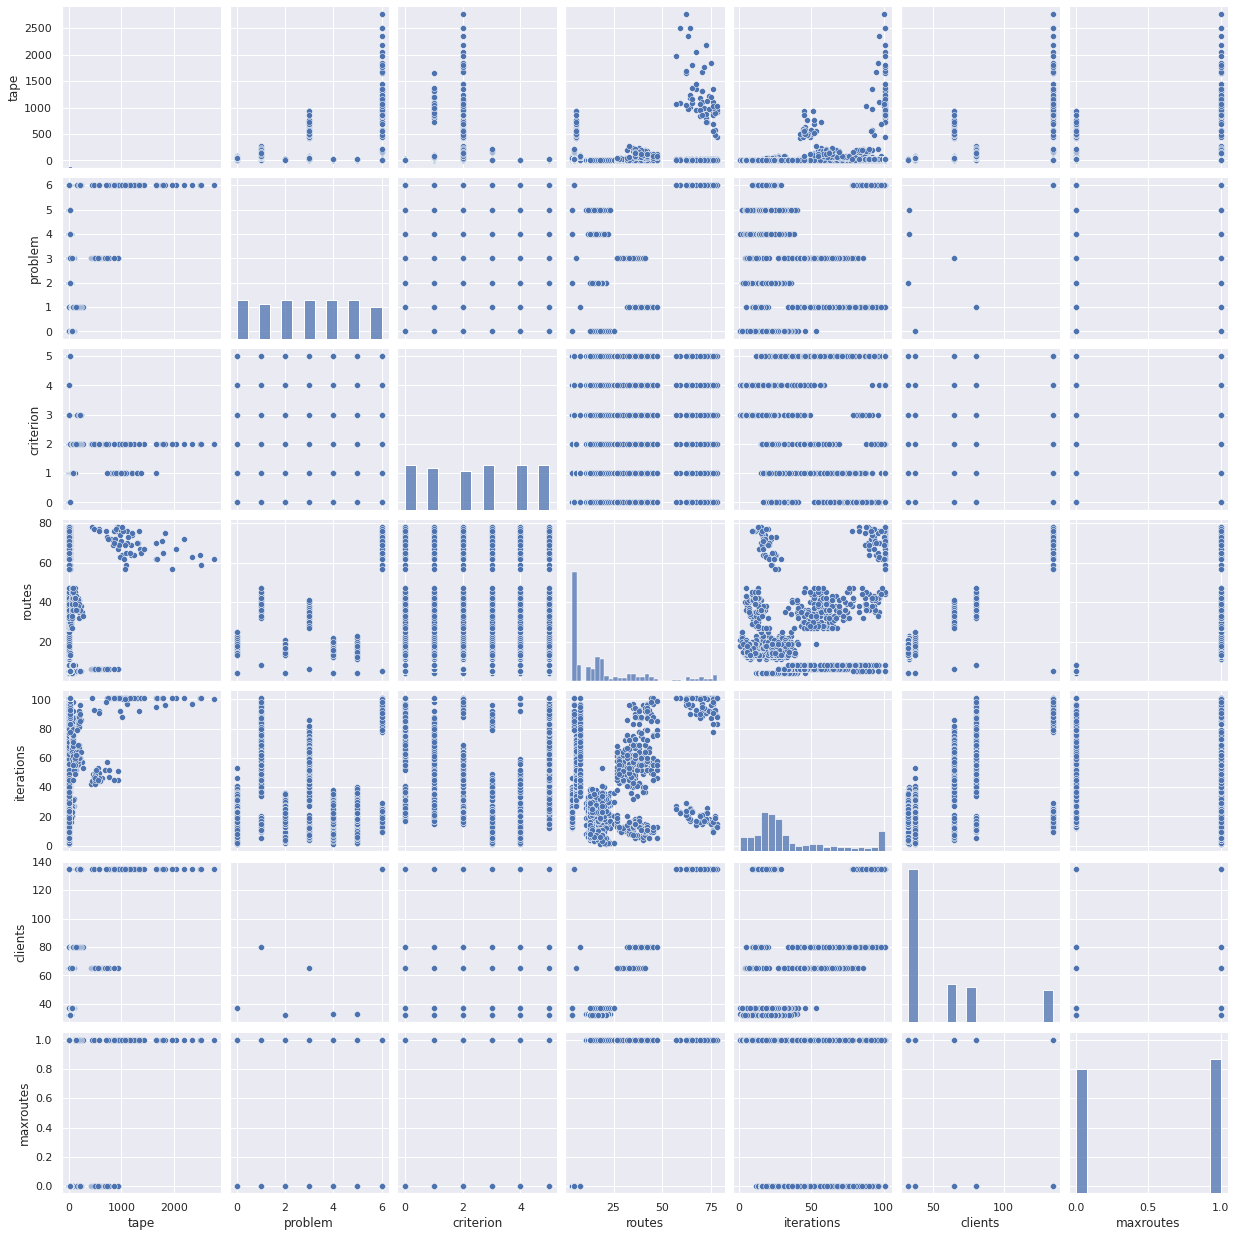

In [165]:
# Scatter plot:

sns.set()
cols = data1.columns.values
sns.pairplot(data1[cols], size=2.5)
plt.show()
